# Data exploration for Synthea 
- Synthea does synthetic patient generation.
- The data is obtained from Synthea generated modules, also can be found at the original [source](https://github.com/synthetichealth/module-validation)

### This notebook contains plots that examine different characteristics of a Synthea population.
- note: most of the following plots are built on-top of the great work done by Palmer  et al, [ref SyntheaPlots](https://github.com/synthetichealth/module-validation/blob/master/notebooks/SyntheaPlots.ipynb)

The original author explors various questions, the below portion borowed are:
- Age
- Race
- Healthcare Cost
- Medication Cost and Usage
- Disease Prevalanece

Jump to the following for new explorations:
- Further Explorations

### Configuration

In [15]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload

data_dir = './module-validation/data-set' # data directory containing synthea data (can either be csvs or zips)
readzips = True # specifies whether the files are compressed (zip) or not


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Needed libraries

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

### Get the data

In [17]:
if readzips:
    compress_opt = 'zip'
    ext = 'zip'
else:
    compress_opt = 'infer'
    ext = 'csv'

patients = pd.read_csv('{}/patients.{}'.format(data_dir, ext), compression=compress_opt)
conditions = pd.read_csv('{}/conditions.{}'.format(data_dir, ext), compression=compress_opt)
meds = pd.read_csv('{}/medications.{}'.format(data_dir, ext), compression=compress_opt)
# only read in first 100k observations
observations = pd.read_csv('{}/observations.{}'.format(data_dir, ext), nrows=1000000, compression=compress_opt)
encounters = pd.read_csv('{}/encounters.{}'.format(data_dir, ext), compression=compress_opt)

### Categorizing (Age and Race)

In [18]:
from dateutil import relativedelta

# pre-processing
def race_clean(race, ethnicity):
    if race.lower() =='white' and ethnicity.lower()=='hispanic':
        return 'hispanic'
    else:
        return race.lower()

def calc_age_in_years(birth_date, death_date=np.nan):
    assert birth_date is not None
    start_date = pd.Timestamp(birth_date) if type(birth_date) is str else birth_date
    end_date = pd.Timestamp.today() if type(death_date) is float else pd.Timestamp(death_date)
    rel_del = relativedelta.relativedelta(end_date, start_date)
    return np.round(rel_del.years + rel_del.months / 12.0, 1)

def get_age_bin(age, bin_size=10):
    idx = np.floor(age/bin_size)
    bin_name = '{}-{}'.format(int(bin_size*idx), int(bin_size*(idx+1)))
    return bin_name

# add new race column (# TODO: fix this to be consistent with census guidelines) and age bins

patients['RACE2'] = patients.apply(lambda x: race_clean(x['RACE'],x['ETHNICITY']), axis=1)
patients['AGE'] = patients.apply(lambda pat: calc_age_in_years(pat['BIRTHDATE'], pat['DEATHDATE']), axis=1)
patients['AGE_BIN'] = patients['AGE'].apply(lambda age: get_age_bin(age))
patients['ALIVE'] = patients['DEATHDATE'].apply(lambda d: type(d) is float)
patients['PATIENT'] = patients['Id']


## First: Age Distrirbutions

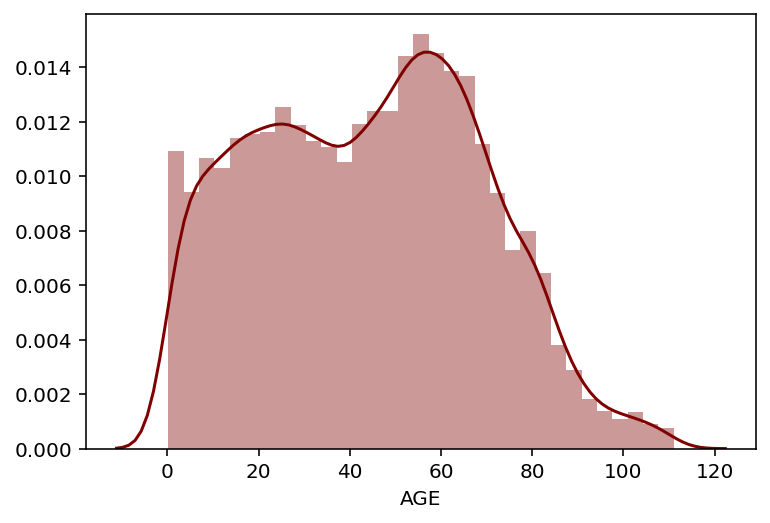

In [19]:
sns.distplot(patients['AGE'], color='maroon')

### Age Distrirbutions by Race

In [20]:
races = set(patients['RACE2'].unique()).difference(['other'])
age_race_data = map(lambda race: patients.loc[patients['RACE2']==race,'AGE'].values, races)

hist_data = [datalist for datalist in age_race_data]

colors = ['#A56CC1', '#A6ACEC', '#63F5EF']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, list(races), show_rug=False)

# Add title
fig.update_layout(title_text='Age Distribution by Race')
fig.show()

### Race/Ethnicity Distribution

In [21]:
measure = 'RACE2'
df = patients
race_cts = df[df['ALIVE']==True].loc[:,[measure, 'PATIENT']].groupby(measure).count()
race_cts['pct'] = np.round(100 * race_cts['PATIENT'] / race_cts['PATIENT'].sum(), 2) 
race_cts['race'] = race_cts.index.tolist()
fig = px.pie(race_cts, values='PATIENT', labels = 'race', names = 'race',
             hover_data=['PATIENT'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Age, Healthcare Expenses and Expense Coverage by Race

Plot that shows pairwise relationships between Age, Healthcare expense, and healthcare coverage by race. Plots in the middle are univariate distributions broken down by race, while the off-diagonal plots are pairwise sactterplots. 

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



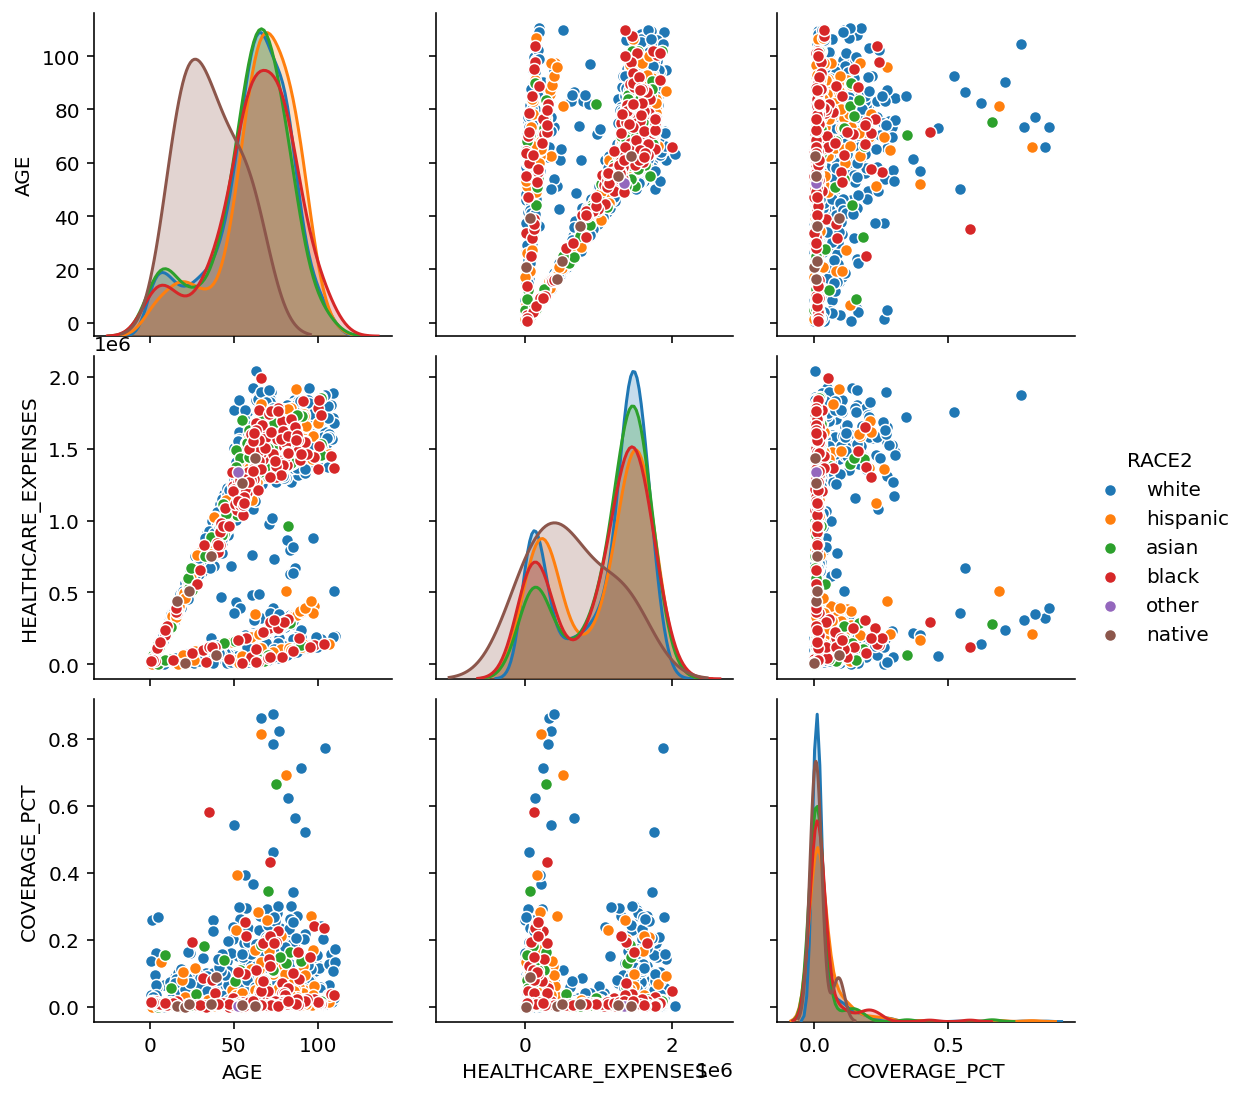

In [22]:
group_col = 'RACE2'
df['COVERAGE_PCT'] = df['HEALTHCARE_COVERAGE'] / df['HEALTHCARE_EXPENSES']
metrics = ['AGE', 'HEALTHCARE_EXPENSES', 'COVERAGE_PCT']

metrics.append(group_col)
df_sub = df.loc[(df['ALIVE']==False) & (df['COVERAGE_PCT'] <=1), metrics]
sns.pairplot(df_sub, hue=group_col)
#df_sub.describe()
plt.show()

### Disease Prevalence

In [23]:
patients.loc[:,'PATIENT'] = patients['Id']
demos = ['PATIENT', 'AGE', 'AGE_BIN', 'RACE2', 'GENDER']
conds_w_demos = conditions.join(patients[demos].set_index('PATIENT'), on='PATIENT')
cond_cts = (conditions.loc[:,['ENCOUNTER','DESCRIPTION']]
            .groupby('DESCRIPTION').count()
            .sort_values(by='ENCOUNTER', ascending=False))
race_cond_cts = conditions.loc[:,['ENCOUNTER', 'DESCRIPTION']]
all_conds = cond_cts.index.tolist()

In [24]:
import numpy as np

def dec_to_pct(decimal):
    return '{}%'.format(np.round(decimal * 100, 2))

# assumes cat_cts index is category name (i.e. result of a counting function)
def simplify_cats(cat_cts, n=10, val_col='ENCOUNTER'):
    if cat_cts.shape[0] < n:
        return cat_cts.sort_values(by=val_col, ascending=True)
    else:
        top_cats = set(cat_cts.sort_values(by=val_col, ascending=False).index.tolist()[:n])
        cat_cts['new_cat'] = [x if x in top_cats else 'Other' for x in cat_cts.index]
        cat_cts = cat_cts.groupby('new_cat').sum()        
        return cat_cts.sort_values(by=val_col, ascending=True)

disorders = set(filter(lambda x: x.endswith('(disorder)'), all_conds))
findings = set(filter(lambda x: x.endswith('(finding)'), all_conds))
situations = set(filter(lambda x: x.endswith('(situation)'), all_conds))

d_cts = cond_cts.filter(items=disorders, axis=0)
# f_cts = cond_cts[cond_cts['Condition'].isin(findings)]
# s_cts = cond_cts[cond_cts['Condition'].isin(situations)]

MAX_CATS = 10
d_cts = simplify_cats(d_cts, MAX_CATS)
# d_cts = simplify_cats(d_cts, MAX_CATS)
# d_cts = simplify_cats(d_cts, MAX_CATS)

#d_cts
pcts = [dec_to_pct(val[0] / d_cts.sum()[0]) for val in d_cts.values]
dis_tr = go.Bar(x=d_cts['ENCOUNTER'], y=d_cts.index, orientation='h', text=pcts, textposition='auto')
d_fig = go.Figure(dis_tr)
d_fig.update_layout(barmode='stack', 
                   title_text='Top 10 Most Prevelanet Disorders in Texas Population')

### Disease Distribution by Race

In [25]:
race_cond_pivot = conds_w_demos.pivot_table(values='ENCOUNTER',index='RACE2',columns='DESCRIPTION', aggfunc=len)
races = set(race_cond_pivot.index.tolist()).difference(['other'])
race_cond_pivot = race_cond_pivot.filter(items=races, axis=0)
# only look at disorders
r_piv = race_cond_pivot.filter(regex='\(disorder\)$', axis=1)
# add column totals for disease normalization
r_piv.loc['Total',:] = r_piv.sum()
# clean up column names
r_piv.columns = [col.replace('(disorder)', '') for col in r_piv.columns]


# get top 10 disorders by total prevalence
top_dis_idxes = sorted([(i,total) for i,total in enumerate(r_piv.loc['Total',:].values)],\
                       key=lambda tup:tup[1], reverse=True)
disease_cols = [tup[0] for tup in top_dis_idxes[:10]]
race_df = r_piv.iloc[:,disease_cols]
# normalize race disease counts by column
races = set(race_df.index.tolist()).difference(['DESC', 'DESCRIPTION', 'Total'])
race_sums = race_df.loc[races,:].sum(axis=1)
race_norms = race_df.loc[races,:]
for i, race in enumerate(races):
    race_norms.loc[race, :] = race_norms.loc[race,:].apply(lambda col_val: np.round(col_val / race_sums[race],2))

race_cond_fig = go.Figure(data=[go.Bar(name=disease.capitalize(), x=race_norms.index.tolist(), y=race_norms[disease], text=race_norms[disease],
                                       textposition='inside') for disease in race_df.columns])

race_cond_fig.update_layout(barmode='stack', title_text='Distribution of Top 10 Disordes by Race')

### Medications

In [27]:
import re

def get_data_from_name(med_name):
    med_name = med_name.lower()
    try:
        keywd = re.findall('([aA-zZ ]+) [0-9]+', med_name)[0]
        keywd = re.sub('^[aA-zZ]{2} ', '', keywd.strip())
    except: keywd = None
    try: dose = re.findall('[0-9\.]+ [mM][gG]', med_name)
    except: dose = None
    return {'keywd': keywd, 'dose': dose}



meds['DESCRIPTION'] = meds['DESCRIPTION'].apply(lambda x: x.lower())
metadata = meds['DESCRIPTION'].apply(lambda x: get_data_from_name(x)).tolist()
met_df = pd.DataFrame(metadata)
meds = pd.concat([meds, met_df], axis=1)

In [28]:
N=15

cts = (meds[['keywd', 'DISPENSES']].groupby(by='keywd').sum()
       .reset_index())
keywds = cts['keywd'].tolist()
cts.index=keywds
cts = simplify_cats(cts, N, 'DISPENSES').reset_index()
cts['pct'] = [dec_to_pct(val / sum(cts['DISPENSES'])) for val in cts['DISPENSES']]
cts = cts[cts['new_cat'] != 'Other']

cts = cts.sort_values(by='DISPENSES', ascending=True)
fig = go.Figure(go.Bar(x=cts['DISPENSES'], y=cts['new_cat'], orientation='h', text=cts['pct'], textposition='auto'))
fig.update_layout(title_text='Top {} Most Frequently Dispensed Medications'.format(N), 
                 xaxis_title = 'Total Dispenses')
fig.update_traces(marker_color='rgb(55,83,109)')
fig.show()

In [29]:
med_pat_matrix = meds.pivot_table(values='DISPENSES',index='PATIENT',columns='keywd', aggfunc=sum)

In [30]:
patient_use_cts = med_pat_matrix.count().sort_values(ascending=False)
patient_use_cts = (patient_use_cts.reset_index()[:N]
                   .rename(columns={0:'count'}))
patient_use_cts['pct'] = [dec_to_pct(val / med_pat_matrix.shape[0]) for val in patient_use_cts['count']]
patient_use_cts = patient_use_cts.sort_values(by='count', ascending=True)
ct_fig = go.Figure(go.Bar(x=patient_use_cts['count'], y=patient_use_cts['keywd'], orientation='h',
                          text=patient_use_cts['pct'], textposition='auto'))
ct_fig.update_layout(title='Medications with Highest Market Penetration', 
                    xaxis_title='# of Patients that have Used')
ct_fig.update_traces(marker_color='rgb(24,162,185)')
ct_fig.show()

In [31]:
from functools import partial
import plotly.express as px

q_25 = partial(pd.Series.quantile, q=0.25)
q_25.__name__ = '25%'
q_75 = partial(pd.Series.quantile, q=0.75)
q_75.__name__ = '75%'
med_use_stats = (med_pat_matrix.agg(['count', 'mean', 'std', 'min', q_25, 'median', q_75, 'max'])
             .transpose()
             .sort_values(by='mean', ascending=False)
             .rename(columns={'mean': 'mean_use_ct', 'count': 'patients'})
            )
med_cost_stats = (meds.loc[:,['keywd','TOTALCOST']]
                  .groupby(by='keywd').describe()
                 )
med_cost_stats.columns = [c[1] + '_cost' for c in med_cost_stats.columns]
med_comb = med_use_stats.join(med_cost_stats)
med_comb['medication'] = med_comb.index

fig = px.scatter(med_comb, x="mean_use_ct", y="mean_cost",
         size="patients", hover_name="medication", log_x=True, log_y=True, size_max=60)
fig.update_layout(title='Medication Bubble Chart', 
                  xaxis_title='Avg. Uses per Patient',
                  yaxis_title ='Avg. Lifetime Cost per Patient')
fig.show()

## Cost

### overall costs

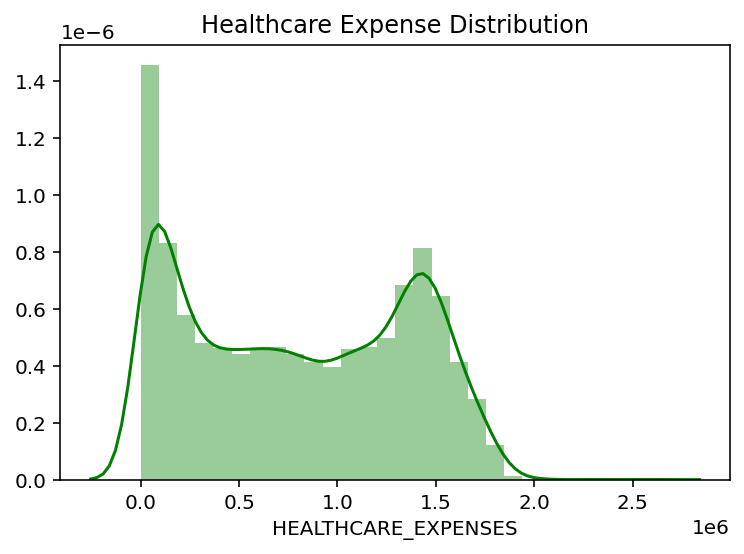

In [34]:
import plotly.figure_factory as ff
import numpy as np
cost_cols = ['PATIENT', 'AGE', 'AGE_BIN', 'GENDER', 'RACE2', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'ZIP']
hist_data = patients['HEALTHCARE_EXPENSES']
ax = sns.distplot(hist_data, color='g')
ax.set(title='Healthcare Expense Distribution')
plt.show()

### Costs By Age

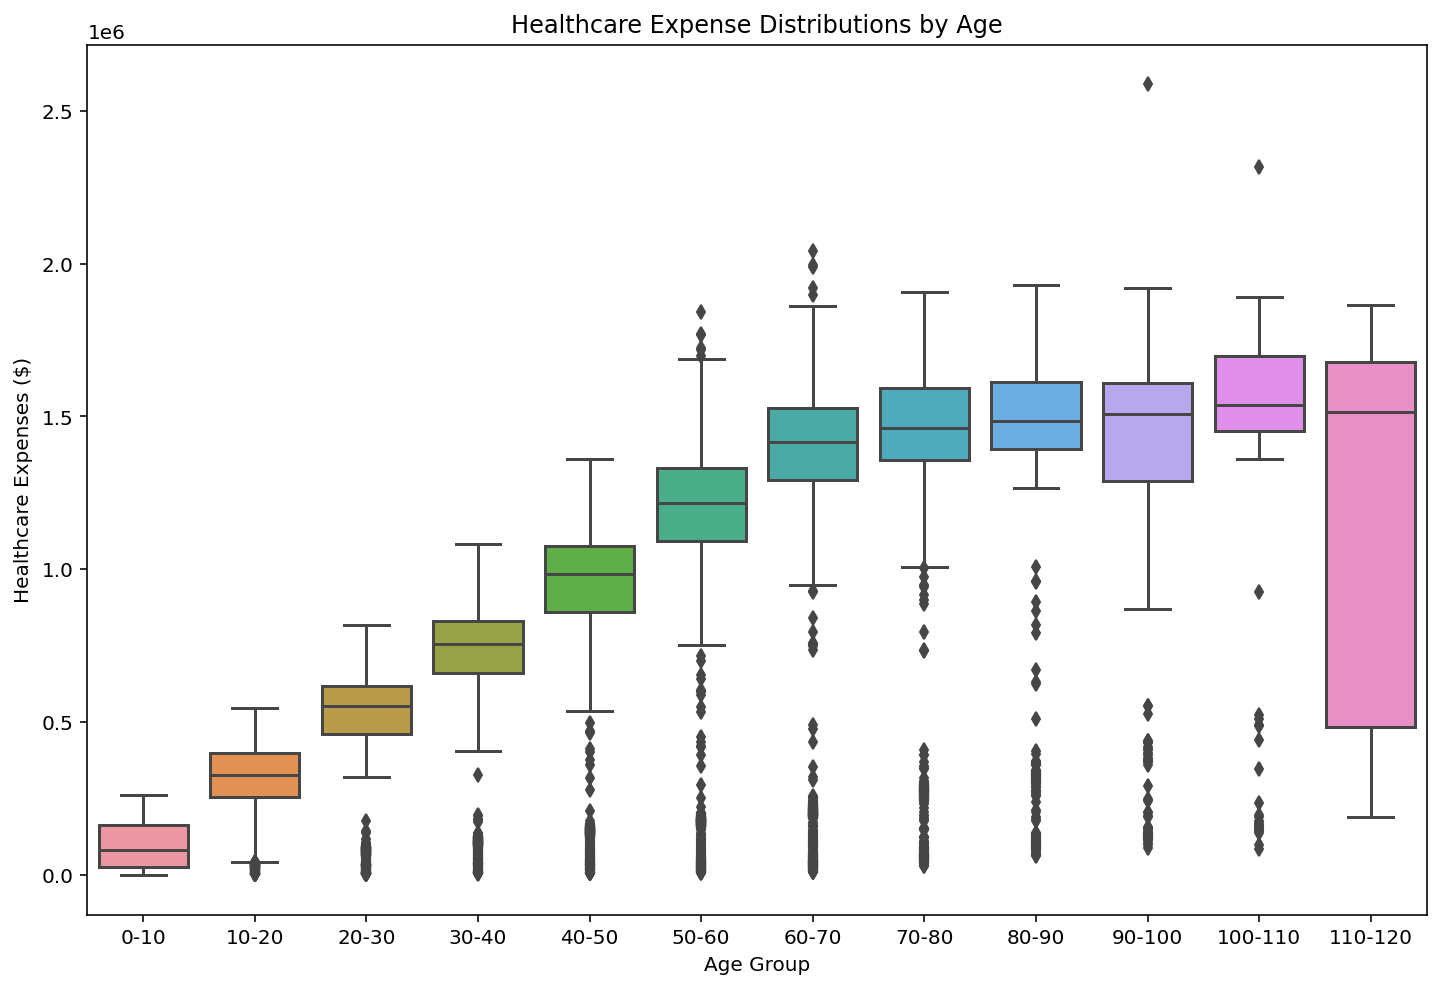

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
patient_sub = patients[cost_cols].sort_values(by='AGE')
sns.boxplot(data=patient_sub, x='AGE_BIN',y='HEALTHCARE_EXPENSES', ax=ax)
ax.set(title='Healthcare Expense Distributions by Age', xlabel='Age Group', ylabel='Healthcare Expenses ($)')
plt.show()

## Further Explorations

In [47]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### Looking into the fields and types of data we have:

In [50]:
patients.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,RACE2,AGE,AGE_BIN,ALIVE,PATIENT,COVERAGE_PCT
0,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,0.014595
1,fec767bd-4edb-4317-8fc5-68d2b0141369,2011-02-15,NaN,999-98-1243,NaN,NaN,NaN,Abram53,Gerhold939,NaN,NaN,NaN,white,nonhispanic,M,Swampscott Massachusetts US,254 Pagac Spur Suite 56,Weymouth,Massachusetts,Norfolk County,2189.0,42.232089,-70.934836,203865.63,2649.84,white,9.4,0-10,True,fec767bd-4edb-4317-8fc5-68d2b0141369,0.012998
2,77f18d69-3755-4995-b019-f2f26913243d,2008-01-24,NaN,999-28-7305,NaN,NaN,NaN,Benito209,Jast432,NaN,NaN,NaN,white,nonhispanic,M,Orange Massachusetts US,527 Hartmann Underpass Apt 93,Brockton,Massachusetts,Plymouth County,2302.0,42.064293,-71.080949,41025.90,10381.73,white,12.5,10-20,True,77f18d69-3755-4995-b019-f2f26913243d,0.253053
3,6c154b1e-c97d-4970-8e01-3a8c412385c4,2003-04-20,NaN,999-33-2334,S99923268,NaN,NaN,Gary33,Dietrich576,NaN,NaN,NaN,white,nonhispanic,M,Boston Massachusetts US,1092 Russel Approach Apt 37,Lowell,Massachusetts,Middlesex County,1852.0,42.681946,-71.349032,374223.35,3203.92,white,17.2,10-20,True,6c154b1e-c97d-4970-8e01-3a8c412385c4,0.008562
4,bac15598-9be3-4f62-99ad-f3f6b7409980,1992-06-17,NaN,999-49-8400,S99986279,X24684811X,Mrs.,Lashaun800,Schiller186,NaN,Feil794,M,black,nonhispanic,F,Worcester Massachusetts US,744 Hirthe Mews Apt 45,Boston,Massachusetts,Suffolk County,2163.0,42.405222,-71.086253,582048.68,2901.36,black,28.1,20-30,True,bac15598-9be3-4f62-99ad-f3f6b7409980,0.004985


In [43]:
conditions.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,2012-03-11,2012-04-24,fec767bd-4edb-4317-8fc5-68d2b0141369,9c4d25eb-faf8-4dcc-92e8-15afbb774af2,65363002,Otitis media
1,2017-11-10,2017-11-17,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,7632b2d9-5ff9-4f22-970e-326b11d4f4c6,444814009,Viral sinusitis (disorder)
2,2019-01-27,2019-04-05,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,3d1441cc-0425-4673-a5e0-06243c2c9f31,30832001,Rupture of patellar tendon
3,2019-05-02,2019-05-15,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2db7c9c7-9231-48c2-beec-452b8d1208a9,43878008,Streptococcal sore throat (disorder)
4,2020-03-04,2020-04-03,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,4a2853cb-4b6e-4e13-a1a6-b890c850b53f,84229001,Fatigue (finding)


In [44]:
meds.head()

,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION,keywd,dose
0,2012-03-11T05:31:11Z,2012-03-25T05:31:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,6e2f1a2d-27bd-3701-8d08-dae202c58632,9c4d25eb-faf8-4dcc-92e8-15afbb774af2,313820,acetaminophen 160 mg chewable tablet,3.72,0.0,1,3.72,NaN,NaN,acetaminophen,[160 mg]
1,2019-01-28T04:57:31Z,2019-04-05T04:57:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,3d1441cc-0425-4673-a5e0-06243c2c9f31,313820,acetaminophen 160 mg chewable tablet,5.58,0.0,2,11.16,NaN,NaN,acetaminophen,[160 mg]
2,2019-05-02T04:57:31Z,2019-05-15T04:57:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,2db7c9c7-9231-48c2-beec-452b8d1208a9,834061,penicillin v potassium 250 mg oral tablet,9.07,0.0,1,9.07,43878008.0,Streptococcal sore throat (disorder),penicillin v potassium,[250 mg]
3,2016-04-20T05:31:11Z,2016-04-27T05:31:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,6e2f1a2d-27bd-3701-8d08-dae202c58632,df0be3ee-e695-4232-840d-288f61402b9c,313782,acetaminophen 325 mg oral tablet,6.93,0.0,1,6.93,10509002.0,Acute bronchitis (disorder),acetaminophen,[325 mg]
4,2016-07-27T05:31:11Z,2016-08-10T05:31:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,6e2f1a2d-27bd-3701-8d08-dae202c58632,d51456c2-cd6c-412f-ab1f-12e184a3b993,313782,acetaminophen 325 mg oral tablet,4.98,0.0,1,4.98,10509002.0,Acute bronchitis (disorder),acetaminophen,[325 mg]


In [45]:
observations.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2013-05-29T04:57:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,0ff7fc71-a1d2-4889-b2ef-d6211f54f0f7,8302-2,Body Height,56.3,cm,numeric
1,2011-02-15T05:31:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,9ccd1741-f8d4-49df-900b-7bb1e0787175,8302-2,Body Height,53.1,cm,numeric
2,2013-05-29T04:57:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,0ff7fc71-a1d2-4889-b2ef-d6211f54f0f7,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,0.0,{score},numeric
3,2011-02-15T05:31:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,9ccd1741-f8d4-49df-900b-7bb1e0787175,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,1.0,{score},numeric
4,2013-05-29T04:57:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,0ff7fc71-a1d2-4889-b2ef-d6211f54f0f7,29463-7,Body Weight,4.7,kg,numeric


In [46]:
encounters.head()

,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,0ff7fc71-a1d2-4889-b2ef-d6211f54f0f7,2013-05-29T04:57:31Z,2013-05-29T05:27:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,b64e856f-b90d-300f-a8cb-4f458389f80e,a19f292a-c6b0-38d1-940c-f02bfe5dd516,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
1,9ccd1741-f8d4-49df-900b-7bb1e0787175,2011-02-15T05:31:11Z,2011-02-15T06:01:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,dc0351e5-9560-3a72-b311-d05aa851ba95,dc024a72-697b-3d1f-a00d-fc31b9993aec,6e2f1a2d-27bd-3701-8d08-dae202c58632,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
2,cf95d9b9-5c7a-4600-a8df-41493ff0cdd4,2011-03-22T05:31:11Z,2011-03-22T06:01:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,dc0351e5-9560-3a72-b311-d05aa851ba95,dc024a72-697b-3d1f-a00d-fc31b9993aec,6e2f1a2d-27bd-3701-8d08-dae202c58632,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
3,9286f24b-8d76-4de0-a463-93168e44adb6,2013-07-03T04:57:31Z,2013-07-03T05:27:31Z,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,b64e856f-b90d-300f-a8cb-4f458389f80e,a19f292a-c6b0-38d1-940c-f02bfe5dd516,5059a55e-5d6e-34d1-b6cb-d83d16e57bcf,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN
4,e5f37370-fc57-4800-9cd4-541eb8841f23,2011-05-24T05:31:11Z,2011-05-24T06:01:11Z,fec767bd-4edb-4317-8fc5-68d2b0141369,dc0351e5-9560-3a72-b311-d05aa851ba95,dc024a72-697b-3d1f-a00d-fc31b9993aec,6e2f1a2d-27bd-3701-8d08-dae202c58632,wellness,410620009,Well child visit (procedure),129.16,129.16,129.16,NaN,NaN


In [53]:
patients.columns,conditions.columns


(Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
        'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
        'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
        'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'RACE2',
        'AGE', 'AGE_BIN', 'ALIVE', 'PATIENT', 'COVERAGE_PCT'],
       dtype='object'),
 Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object'))

In [55]:
## 
patients_conditions = (patients.merge(conditions, left_on='Id', right_on='PATIENT')
          .reindex(columns=['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
        'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
        'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'COUNTY', 'ZIP',
        'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE', 'RACE2',
        'AGE', 'AGE_BIN', 'ALIVE', 'PATIENT', 'COVERAGE_PCT',
        'START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION']))

In [56]:
patients_conditions.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,RACE2,AGE,AGE_BIN,ALIVE,PATIENT,COVERAGE_PCT,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION
0,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,NaN,0.014595,2017-11-10,2017-11-17,NaN,7632b2d9-5ff9-4f22-970e-326b11d4f4c6,444814009,Viral sinusitis (disorder)
1,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,NaN,0.014595,2019-01-27,2019-04-05,NaN,3d1441cc-0425-4673-a5e0-06243c2c9f31,30832001,Rupture of patellar tendon
2,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,NaN,0.014595,2019-05-02,2019-05-15,NaN,2db7c9c7-9231-48c2-beec-452b8d1208a9,43878008,Streptococcal sore throat (disorder)
3,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,NaN,0.014595,2020-03-04,2020-04-03,NaN,4a2853cb-4b6e-4e13-a1a6-b890c850b53f,84229001,Fatigue (finding)
4,2b1bb3ce-8bc7-4cb8-aee4-7daaa3b5bbac,2013-05-29,NaN,999-18-4824,NaN,NaN,NaN,Keisha459,Kemmer137,NaN,NaN,NaN,white,nonhispanic,F,Millbury Massachusetts US,611 Bruen Orchard Unit 23,Everett,Massachusetts,Middlesex County,2149.0,42.362378,-71.092586,161864.65,2362.36,white,7.2,0-10,True,NaN,0.014595,2020-03-04,2020-04-03,NaN,4a2853cb-4b6e-4e13-a1a6-b890c850b53f,267036007,Dyspnea (finding)
